<a href="https://colab.research.google.com/github/sun89314/527-project/blob/main/527.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load data


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import folium

# for ML:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
# import eli5 # Feature importance evaluation

In [4]:
df = pd.read_csv('/content/drive/MyDrive/527/hotel_bookings.csv')

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# getting data information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# data cleaning


In [7]:
nullArray = df.isnull().sum()
nullArray = nullArray[nullArray > 0]
print(nullArray)

children         4
country        488
agent        16340
company     112593
dtype: int64


In [8]:
#filling children,since most booking has zero children ,so we fill children as 0
print(df['children'].value_counts())
df['children'].fillna(0, inplace=True)

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64


In [9]:
#df['country'].value_counts() since there are 177 different country values, it is not ideal to assgin null to any one of them
df['country'].fillna('unknown', inplace=True)

In [10]:
print("the null rate of company roll is ",1-df['company'].count()/df['company'].size,'so we decide to delete this category')
df.drop('company', axis=1, inplace=True)

the null rate of company roll is  0.943068933746545 so we decide to delete this category


In [11]:
#probably booking with people themselves，so replace null with new category 0
df['agent'].fillna(0.0, inplace=True)

In [12]:
#data description says sc = undefined
df["meal"].replace("Undefined", "SC", inplace=True)

In [13]:
noAdults = df.loc[df["adults"]==0].index
df.drop(df.index[noAdults], inplace=True)

# decriptive analysis


In [82]:
#we want to know the information of the guest that actually visited
visited = df.loc[df['is_canceled'] == 0]
visited.shape

(74872, 31)

In [83]:
visited.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

Question 1: what is the top overall travel season?

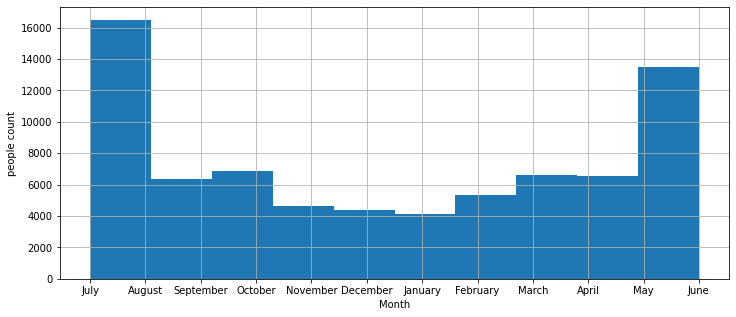

In [84]:
fig = plt.figure(figsize=(12, 5))
visited['arrival_date_month'].hist()
plt.xlabel('Month')
plt.ylabel('people count')
plt.show()

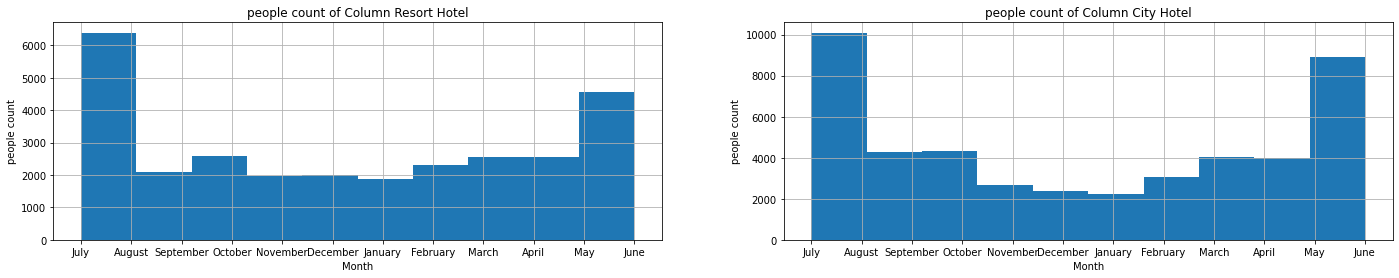

In [85]:
hotel_type = visited['hotel'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(hotel_type), figsize=(24, 4))
for i,value in enumerate(hotel_type):
  visited.loc[visited['hotel'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

what kind of the hotel does people with children most likely to go?

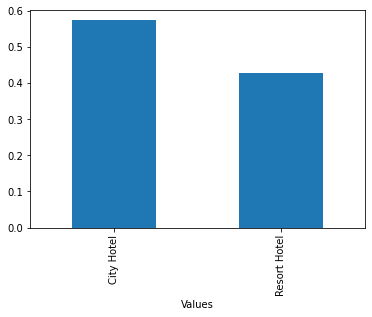

In [86]:
withBaby = visited.loc[visited['children']+ visited['babies'] >0]
fig = plt.figure(figsize=(6, 4))
hotelPreferRate = withBaby['hotel'].value_counts(normalize = True)
ax = hotelPreferRate.plot(kind = 'bar')
ax.set_xlabel('Values', rotation=0)
plt.show()

should hotel prepare more children stuff in specific month?

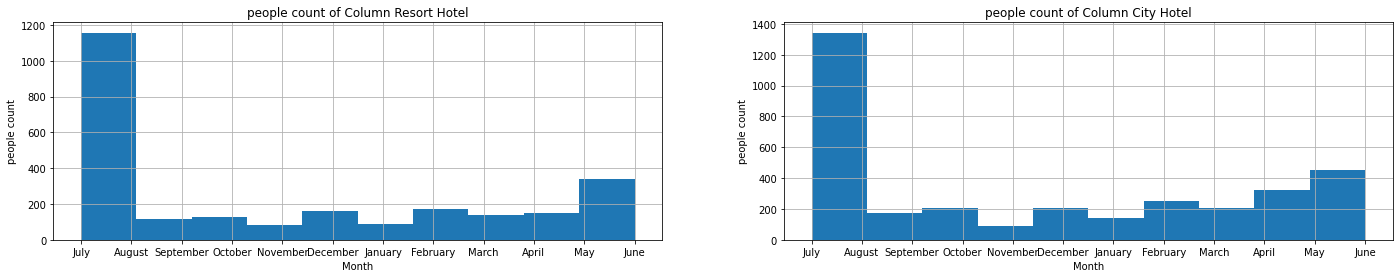

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=len(hotel_type), figsize=(24, 4))
for i,value in enumerate(withBaby['hotel'].unique()):
  withBaby.loc[withBaby['hotel'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

does specific year affect which month people want to travel?

In [88]:
from pandas.core.base import value_counts
fig = plt.figure(figsize=(12, 5))
visited.groupby('arrival_date_year')['arrival_date_month'].value_counts()

arrival_date_year  arrival_date_month
2015               October               3218
                   September             3016
                   August                2281
                   December              1935
                   November              1851
                   July                  1515
2016               October               3669
                   May                   3554
                   September             3365
                   April                 3359
                   March                 3337
                   August                3214
                   June                  3188
                   July                  3053
                   November              2799
                   February              2539
                   December              2442
                   January               1683
2017               May                   3541
                   July                  3316
                   March                 3

<Figure size 864x360 with 0 Axes>

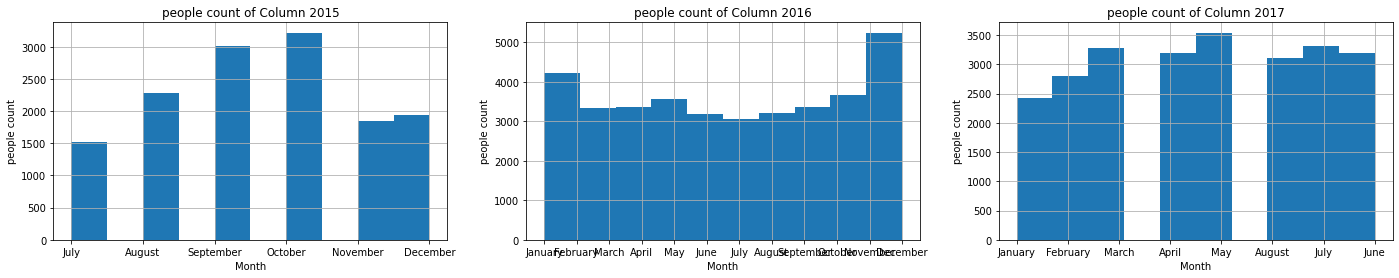

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 4))
for i,value in enumerate(visited['arrival_date_year'].unique()):
  visited.loc[visited['arrival_date_year'] == value]['arrival_date_month'].hist(ax=axes[i])
  axes[i].set_title('people count of Column {}'.format(value))
  axes[i].set_xlabel('Month')
  axes[i].set_ylabel('people count')

does people prefer to arrive at particular day?

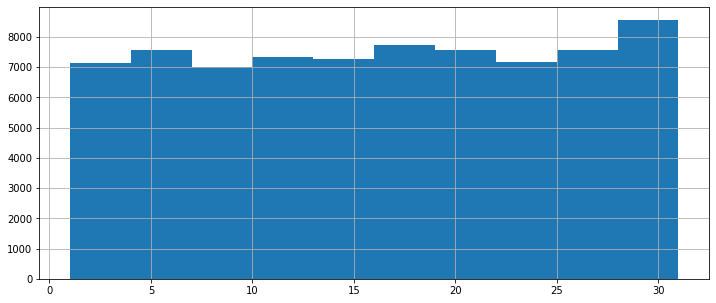

In [90]:
fig = plt.figure(figsize=(12, 5))
visited['arrival_date_day_of_month'].hist()
# plt.xlabel('Month')
# plt.ylabel('people count')
plt.show()

which country is more porpular? 

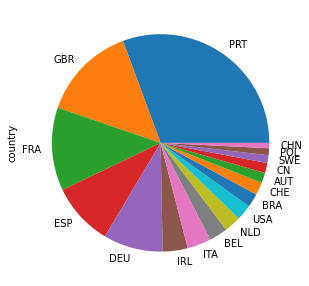

In [91]:
s = visited['country'].value_counts()>500
idx = s[s.array == True].index
porpularCountries = visited[visited['country'].isin(idx)]['country'].value_counts()
# print(porpularCountries)
fig = plt.figure(figsize=(12, 5))
ax = porpularCountries.plot(kind = 'pie')
plt.show()